---
<p style="text-align: center;font-size: 2em;font-weight: bold;">
Projet numérique de Probabilités 2025/26
</p>

---


# Introduction

On va s'intéresser à la simulation de champs aléatoires gaussiens. On peut définir un champ aléatoire Gaussien comme une collection de variables aléatoires indexées par un ensemble telles que toute combinaison linéaire finie de ces variables aléatoires suit une loi normale. Pour simplifier, nous nous intéresserons à des champs aléatoires gaussiens définis sur une grille régulière de points dans un domaine  $\mathbb{R}^2$. 

Un champ aléatoire Gaussien est entièrement caractérisé par son espérance et sa fonction de covariance. L'espérance est une fonction qui attribue à chaque point du domaine la valeur moyenne de la variable aléatoire associée à ce point. La fonction de covariance est une fonction qui décrit comment les variables aléatoires associées à deux points différents du domaine sont corrélées entre elles. 

Un exemple classique de fonction de covariance est la fonction exponentielle quadratique (ou gaussienne) définie par :
$$C(x, y) = \sigma^2 \exp\left(-\frac{\|x - y\|^2}{a}\right)$$
où  $\sigma^2$ est la variance,  $a$ est le facteur d'échelle, et $\|x - y\|$ est la distance euclidienne entre les points  $x$ et $y$.
Une telle fonction de covariance implique que les points proches dans le domaine ont des valeurs de champ aléatoire fortement corrélées, tandis que les points éloignés ont des valeurs faiblement corrélées. Elle est souvent utilisée pour modéliser des phénomènes naturels où la corrélation diminue avec la distance. 

Dans ce projet, nous allons implémenter une méthode pour simuler des champs aléatoires gaussiens sur une grille régulière de points dans un domaine  $\mathbb{R}^2$. Nous utiliserons dans un premier temps la méthode de la décomposition de Cholesky pour générer des échantillons de champs aléatoires gaussiens à partir de leur fonction de covariance. Dans un second temps, nous explorerons un méthode plus efficace basée sur la représentation spectrale de la fonction de covariance. Enfin, nous verrons comment conditionner ces simulations sur des observations ponctuelles.

# Simulation par la méthode de Cholesky

Quitte à réarranger les points de la grille, on peut supposer que l'on a une liste finie de points  $x_1, x_2, \ldots, x_n$ dans  $\mathbb{R}^2$ où l'on souhaite simuler le champ aléatoire Gaussien. La fonction de covariance  $C$ permet de construire la matrice de covariance  $K$ définie par :

$$K_{ij} = C(x_i, x_j)$$

On va implementer la méthode de Cholesky pour générer des réalisations de champs aléatoires gaussiens à partir de cette matrice de covariance.

1. Ecrire une fonction "covariance_gaussienne" qui prend en entrée une matrice de distances, ainsi que les paramètres  $\sigma^2$ et  $a$, et qui retourne la valeur de la fonction de covariance gaussienne du vecteur associé.

In [41]:
import numpy as np
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt

np.random.seed(12345)

def covariance_gaussienne(matrice_dist, sigma2,a):
    return sigma2*np.exp(-matrice_dist**2/a)


2. Discrétiser le domaine  $[0, 1] \times [0, 1]$ en une grille régulière de  $n \times n$ points (par exemple,  $n = 50$). Construire la matrice de distances entre tous les points de la grille.

In [42]:
pas=50
grille=np.linspace(0,1,pas)
X,Y=np.meshgrid(grille,grille)
points = np.stack((X, Y), axis=-1).reshape(-1, 2)
mat_dist=distance_matrix(points, points)
print(mat_dist)

[[0.         0.02040816 0.04081633 ... 1.38565267 1.3998572  1.41421356]
 [0.02040816 0.         0.02040816 ... 1.3716047  1.38565267 1.3998572 ]
 [0.04081633 0.02040816 0.         ... 1.35771815 1.3716047  1.38565267]
 ...
 [1.38565267 1.3716047  1.35771815 ... 0.         0.02040816 0.04081633]
 [1.3998572  1.38565267 1.3716047  ... 0.02040816 0.         0.02040816]
 [1.41421356 1.3998572  1.38565267 ... 0.04081633 0.02040816 0.        ]]


3. Utiliser la fonction "covariance_gaussienne" pour construire la matrice de covariance $K$ en évaluant la fonction de covariance pour chaque paire de points dans la grille puis calculer la décomposition de Cholesky de $K$ (voir *np.linalg.cholesky*).

On choisira ici  $\sigma^2 = 1$ et  $a = 0.05$.

NB : Pour assurer la stabilité numérique, on peut ajouter un petit terme de régularisation à la diagonale de la matrice de covariance avant de calculer la décomposition de Cholesky (par exemple,  $10^{-10} I$ où  $I$ est la matrice identité).

In [43]:
sigma2 = 1.0
a = 0.05
K = covariance_gaussienne(mat_dist, sigma2, a)
K_stab=K+np.eye(K.shape[0])*1e-10

cholesky = np.linalg.cholesky(K_stab)

4. Générer et représenter une réalisation du champ aléatoire Gaussien centré et de covariance $K$.

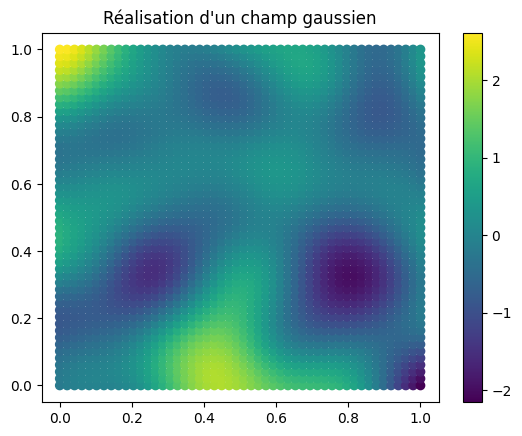

In [44]:
# On génère un vecteur de variables aléatoires suivant une loi normale centrée et de covariance K
X = cholesky @ np.random.randn(K.shape[0])
# On affiche le champ gaussien
plt.scatter(points[:,0], points[:,1], c=X, cmap='viridis')
plt.colorbar()
plt.title('Réalisation d\'un champ gaussien')
plt.show()

5. Essayer d'augmenter le nombre de pas de discrétisation. Que remarquez-vous ? Expliquer pourquoi.

Nous avons remplacé le pas de 50 par 500 et nous nous sommes rendus compte que la durée d'exécution du programme augmente très fortement. En effet, l'exécution n'était toujours pas terminée au bout de 13 min alors que pour 50 points, elle s'effectue en 1,2 s. Cela s'explique par la faible efficacité des programmes mobilisés: dans un premier temps, la fonction distance_matrix, comme elle calcule la distance pour chaque paire de n points, est de complexité quadratique. Pire encore, après avoir fait des recherches, nous avons noté. que l'algorithme de la décomposition de Cholesky possède une complexité en $O(n^3)$ ce qui explique le temps de calcul.

# Simulation par la méthode spectrale 

Vu les limitations de la méthode de Cholesky pour des grilles fines, nous allons explorer une méthode alternative basée sur la représentation spectrale de la fonction de covariance. 

1. Soit $C(h) = \exp\left(-\frac{\|h\|^2}{a}\right)$, où $h \in \mathbb{R}^2$. Montrer que :
$$ C(h) = \int_{\mathbb{R}^2} \cos(\langle w, h \rangle) \frac{a}{4\pi}\exp\left(-\frac{a\|w\|^2}{4}\right) dw $$

NB: on pourra s'inspirer du calcul de la fonction caractéristique d’un vecteur gaussien en annexe du chapitre IV du cours.

Réponse:

On pose Z=(X,Y) avec $X,Y\sim \mathcal{N}(0,\frac{2}{a})$. On suppose X et Y indépendantes.

Soit $h \in \mathbb{R^2}$,

D'une part, on remarque que $\phi_Z(h)=\exp(-\frac{1}{2}\langle h,Ch \rangle)=\exp(-\frac{\lVert h \rVert^2}{a})$ d'après la formule donnée dans l'annexe du chapitre IV.

D'autre part, $$\phi_Z(h)=\mathbb{E}(\exp(i\langle h,Z \rangle))
                        =\int_{\mathbb{R}^2}\exp(i\langle h,z \rangle)\mathbb{P}_Z(dz)
                        =\frac{a}{4\pi}\int_{\mathbb{R}}\exp(ih_1x)\exp(-\frac{ax^2}{4})dx\int_{\mathbb{R}}\exp(ih_2y)\exp(-\frac{ay^2}{4})dy$$ par Fubini, et comme on suppose X et Y indépendantes on a bien le produit des densités.

Or $$\int_{\mathbb{R}}\exp(ih_1x)\exp(-\frac{ax^2}{4})dx=\int_{\mathbb{R}}\cos(h_1x)\exp(-\frac{ax^2}{4})dx$$ par imparité de la partie imaginaire.

En utilisant la formule $\cos(h_1x)\cos(h_2y)=\frac{1}{2}(\cos(h_1x+h_2y)+\cos(h_1x-h_2y)=\frac{1}{2}(\cos(\langle h,\omega \rangle)+\cos(h_1x-h_2y)$ et le changement de variable u=-y dans l'intégrale, on trouve:

$$C(h)=\phi_Z(h)=\int_{\mathbb{R}^2} \cos(\langle w, h \rangle) \frac{a}{4\pi}\exp\left(-\frac{a\|w\|^2}{4}\right) dw $$

2. Soient $W$ et $\Phi$ deux variables aléatoires indépendantes, de lois respectives $\mathcal{N}(0, \frac{2}{a} I_2)$, avec $I_2$ la matrice identité de dimension 2, et $\mathcal{U}[0, 2\pi[$. Montrer que la variable aléatoire définie en tout point $x \in \mathbb{R}^2$ par :
$$ Z(x) = \sqrt{2} \cos(\langle W, x \rangle + \Phi) $$
est d'espérance nulle et de fonction de covariance $C$.

Réponse: 
* Soit $x\in\mathbb{R^2}$, montrons que Z(x) est d'espérance nulle.

$$ Z(x) = \sqrt{2} \cos(\langle W, x \rangle + \Phi) = \sqrt{2} (\cos(\langle W, x \rangle)\cos(\Phi)-\sin(\langle W, x \rangle)\sin(\Phi)) $$

Par linéarité de l'espérance et indépendance des deux variables aléatoires, on a donc:
 $$\mathbb{E}(Z(x))=\sqrt{2}\mathbb{E}(\cos(\langle W, x \rangle))\mathbb{E}(\cos(\Phi))-\mathbb{E}(\sin(\langle W, x \rangle))\mathbb{E}(\sin(\Phi))$$

Or $\mathbb{E}(cos(\Phi))=\int_0^{2\pi}cos(\phi)\frac{1}{2\pi}d\phi=0$ et de même pour $\sin(\Phi)$ donc $\mathbb{E}(Z(x))=0$



* Calcul de la fonction de covariance:

Soient $x,y \in \mathbb{R^2}$, 

$Cov(Z(x),Z(y))=\mathbb{E}(Z(x)Z(y))$ car Z est d'espérance nulle.

Or: $$Z(x)Z(y)=2\cos(\langle W, x \rangle + \Phi)\cos(\langle W, y \rangle + \Phi)=\cos(\langle W, x-y \rangle)+\cos(\langle W, x+y \rangle + 2\Phi)$$

L'espérance du terme de droite est nulle pour les mêmes raisons que pour le calcul d'espérance précedemment effectué.

Il nous reste donc à traiter le terme de gauche:

A l'aide de la formule de transfert, on obtient: $$\mathbb{E}(\cos(\langle W, x-y \rangle))=\int_\mathbb{R^2}\cos(\langle w, x-y \rangle)f_Z(w)dw$$

La formule du cours de probabilités III sur les vecteurs gaussiens nous permet d'affirmer que $f_Z(w)=\frac{a}{4\pi}\exp(-\frac{a \lVert w \rVert^2}{4})$ car $\det(\frac{2}{a})=(\frac{2}{a})^2$

En posant $h=x-y$, on trouve donc bien que $Cov(Z(x),Z(y))=C(h)$ la fonction trouvée à la question précédente.


3. Soient les suites de variables aléatoires indépendantes $(W_n)_{n \in \mathbb{N}}$ et $(\Phi_n)_{n \in \mathbb{N}}$ telles que $W_n \sim \mathcal{N}(0, \frac{2}{a} I_2)$ et $\Phi_n \sim \mathcal{U}([0, 2\pi])$. Montrer que pour tout ensemble fini de points  $x_1, \ldots, x_n$ dans  $\mathbb{R}^2$ , le vecteur aléatoire $Y = (Y(x_1), \ldots, Y(x_n))$ où :
$$ Y(x_i) = \sqrt{\frac{2}{N}} \sum_{k=1}^{N} \cos(\langle W_k, x_i \rangle + \Phi_k) $$
tend vers un vecteur aléatoire de loi normale multivariée d'espérance nulle et de matrice de covariance $K$ définie par  $K_{ij} = C(x_i - x_j)$.

Soient $x_1,...,x_n \in \mathbb{R^2}$

* Calcul de l'espérance de Y:

$$\mathbb{E}(Y)=(\mathbb{E}(Y(x_1)),...,\mathbb{E}(Y(x_n)))$$

Soit $i \in {1,...,n}$,

$$\mathbb{E}(Y(x_i))=\sqrt{\frac{2}{N}} \sum_{k=1}^{N} \mathbb{E}(\cos(\langle W_k, x_i \rangle + \Phi_k))$$
par linéarité de l'espérance.

Or d'après la question précédente, $\mathbb{E}(\cos(\langle W_k, x_i \rangle + \Phi_k))=0$, donc $\mathbb{E}(Y)=0$.

* Calcul de la matrice de covariance:

Soient $i,j \in {1,...,n}$,

$$Cov(Y(x_i),Y(x_j))=\mathbb{E}(Y(x_i)Y(x_j))=\frac{1}{N}\sum_{k=1}^N\sum_{l=1}^N\mathbb{E}(\sqrt{2}\cos(\langle W_k, x_i \rangle + \Phi_k)\sqrt{2}\cos(\langle W_l, x_j \rangle + \Phi_l))$$

Les termes tels que $l≠k$ s'annulent car  $(W_n)_{n \in \mathbb{N}}$ et $(\Phi_n)_{n \in \mathbb{N}}$ sont des suites de variables aléatoires indépendantes, et l'espérance de $\cos(\langle W_k, x_i \rangle + \Phi_k)$ est nulle.
Ensuite, dans le cas $k=l$, d'après les résultats de la question précédente, on a $$\mathbb{E}(\sqrt{2}\cos(\langle W_k, x_i \rangle + \Phi_k)\sqrt{2}\cos(\langle W_k, x_j \rangle + \Phi_k))=C(x_i-x_j)$$

On trouve donc que la matrice de covariance de Y est bien K pour tout $N \in \mathbb{N}$.

* Passage à la limite:

On pose $S_N=\sum_{k=1}^N Z_k$, avec $Z_k=(\sqrt{2}\cos(\langle W_k, x_1 \rangle + \Phi_k),...,\sqrt{2}\cos(\langle W_k, x_n \rangle + \Phi_k))$ des variables indépendantes (par indépendance des suites $(W_n)$ et $(\Phi_n)$) et de même loi.

Leurs composantes sont de carré intégrable: *A justifier*

Le théorème central-limite multidimensionnel nous permet alors d'affirmer que $Y=\frac{1}{\sqrt{N}}S_N \xrightarrow{\mathcal L} \mathcal{N}(0, K)$



4. Implémenter une fonction basée sur cette méthode pour simuler un champ aléatoire gaussien sur une grille régulière de points dans le domaine  $[0, 1] \times [0, 1]$. Cette fonction prendra en entrée les coordonnées des points de la grille, $a$ et  $N$ et retournera une réalisation du champ aléatoire gaussien simulé.

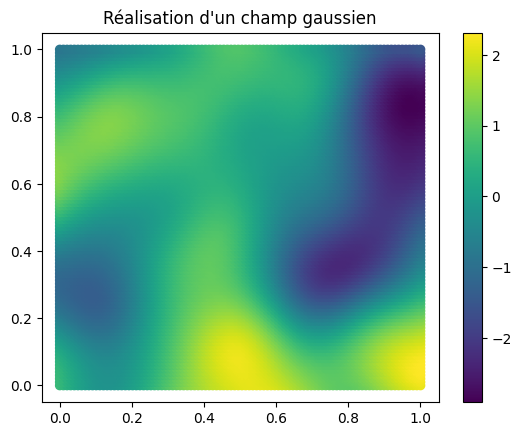

In [45]:
pas=100
ligne=np.linspace(0,1,pas)
X,Y=np.meshgrid(ligne,ligne)

def mspectrale(X,Y,a,N):
    points = np.stack((X, Y), axis=-1).reshape(-1, 2)
    # on génère N phi de dimension 1 suivant une loi uniforme
    phi = np.random.uniform(0, 2*np.pi, size=N)
    # on génère N W de dimension 2 suivant une loi normale
    W = np.sqrt(2/a) * np.random.randn(N, 2)
    Yvals = np.sqrt(2/N) * np.sum(np.cos(points @ W.T + phi), axis=1)
    return Yvals.reshape(pas, pas)

Z = mspectrale(X, Y, a, 1000)
plt.scatter(X.flatten(), Y.flatten(), c=Z.flatten(), cmap='viridis')
plt.colorbar()
plt.title('Réalisation d\'un champ gaussien')
plt.show()

5. Tester cette fonction pour différentes valeurs du nombre de points de discrétisation et de $N$. Proposer un diagnostic permettant de calibrer $N$ afin que les résultats soient conformes aux attentes. Comparer les résultats obtenus avec ceux de la méthode de Cholesky. Quels sont les avantages et les inconvénients de chaque méthode ?

In [46]:
sigma2 = 1.0
a = 0.05


# Simulation conditionnelle 

On suppose désormais que l'on dispose de valeurs observées du champ aléatoire Gaussien en certains points du domaine. On souhaite simuler des réalisations conditionnelles du champ aléatoire Gaussien en tenant compte de ces observations. On travaillera désormais avec une grille de taille $100 \times 100$.
Soit $X$ un vecteur aléatoire Gaussien partitionné en deux sous-vecteurs $X_1$ et $X_2$, où $X_1$ représente les points observés et $X_2$ les points non observés. 

1. Rappeler l'expression de la distribution jointe de $X = (X_1, X_2)$ puis de la distribution conditionnelle de $X_2$ sachant $X_1$. Montrer que la différence entre l'espérance conditionnelle et le vecteur des points non observés est un vecteur Gaussien d'espérance nulle indépendant du vecteur des points non observés.

Réponse: On pose $\mu_1,\mu_2,\sigma_1,\sigma_2$ tels que $X_1 \sim \mathcal{N}(\mu_1,\sigma_1^2)$ et $X_2 \sim \mathcal{N}(\mu_2,\sigma_2^2)$

* Distribution jointe: 

Alors $X=(X_1,X_2)\sim\mathcal{N}((\mu_1,\mu_2),K)$ tel que 
$K= \begin{pmatrix} \sigma_1^2 &  Cov(X_1,X_2) \\ Cov(X_2,X_1) & \sigma_2^2 \end{pmatrix}$

* Distribution conditionnelle de $X_2$ sachant $X_1$:

Le cours sur les vecteurs gaussiens du chapitre probabilité III nous indique que la variable aléatoire $X_2|X_1=x$ est gaussienne d'espérance: $$\mathbb{E}(X_2|X_1=x)=\mu_2+Cov(X_2,X_1)(\sigma_1^2)^{-1}(x-\mu_1)$$ et de matrice de covariance $$\sigma_2^2-Cov(X_2,X_1)(\sigma_1^2)^{-1}Cov(X_1,X_2)$$

Donc $X_2 | X_1$ est une gaussienne dont l'espérance est la variable aléatoire $\mathbb{E}(X_2 | X_1)=\mu_2+Cov(X_2,X_1)(\sigma_1^2)^{-1}(X_1-\mu_1)$

* Etude de $\mathbb{E}(X_2 | X_1)-X_2:$

$\mathbb{E}(X_2 | X_1)-X_2$ suit une loi gaussienne car c'est une combinaison linéaire de gaussiennes. De plus, par la formule de l'espérance totale, $$\mathbb{E}(\mathbb{E}(X_2 | X_1))=\mathbb{E}(X_2)$$ 

Donc par linéarité de l'espérance, $$\mathbb{E}(\mathbb{E}(X_2 | X_1)-X_2)=0$$

En supposant que la question demande de montrer l'indépendance avec $X_1$:

$$Cov((\mathbb{E}(X_2 | X_1)-X_2), X_1)=Cov(\mu_2+Cov(X_2,X_1)(\sigma_1^2)^{-1}(X_1-\mu_1),X_1)=Cov(X_2,X_1)(\sigma_1^2)^{-1}Cov(X_1,X_1)-Cov(X_2,X_1)=0$$

Comme ce sont des variables aléatoires gaussiennes, la non-corrélation implique l'indépendance, donc la différence entre l'espérance conditionnelle et le vecteur des points non observés est un vecteur Gaussien d'espérance nulle indépendant du vecteur des points observés.


On va donc chercher à simuler directement cette différence pour obtenir des réalisations conditionnelles du champ aléatoire Gaussien.

2. Générer 50 points uniformément répartis dans le domaine  $[0, 1] \times [0, 1]$ et simuler des observations du champ aléatoire Gaussien en ces points.


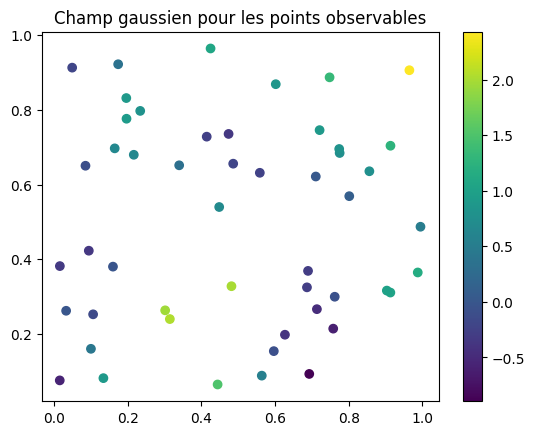

In [47]:
pas=50
ligne=np.linspace(0,1,pas)
X,Y=np.meshgrid(ligne,ligne)

obs_pts = np.random.rand(50,2)

#on reprend la méthode de la partie 1
mat_dist=distance_matrix(obs_pts, obs_pts)
sigma2 = 1.0
a = 0.05
K = covariance_gaussienne(mat_dist, sigma2, a)
K_stab=K+np.eye(K.shape[0])*1e-10

cholesky = np.linalg.cholesky(K_stab)

gauss = cholesky @ np.random.randn(K.shape[0])
plt.scatter(obs_pts[:,0], obs_pts[:,1], c=gauss, cmap='viridis')
plt.colorbar()
plt.title('Champ gaussien pour les points observables')
plt.show()



3. Calculer l'espérance conditionnelle aux points de la grille et la représenter.

NB : Pour assurer la stabilité numérique, on doit ajouter un terme de régularisation plus important à la diagonale de la matrice de covariance avant de calculer son inverse ($10^{-2} I$ conviendra ici).

In [48]:
sigma2 = 1.0
a = 0.05



4. Pour générer de manière indépendante la différence entre l'espérance conditionnelle et le vecteur des points non observés, on génère une seconde réalisation du champ aléatoire aux points de la grille **et** aux coordonnées des points observés par la méthode spectrale. On calcule ensuite la différence entre cette réalisation et l'espérance conditionnelle sachant les valeurs simulées aux coordonnées des points observés. Enfin, on additionne cette différence à l'espérance conditionnelle sachant les observations pour obtenir une réalisation conditionnelle du champ aléatoire Gaussien sur la grille. Implémenter cette approche et représenter une réalisation conditionnelle du champ aléatoire Gaussien sur la grille.

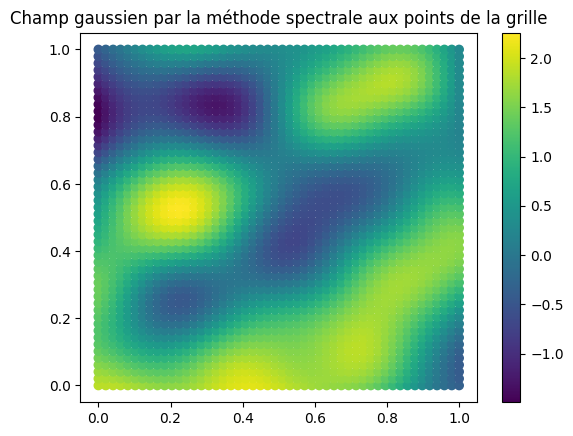

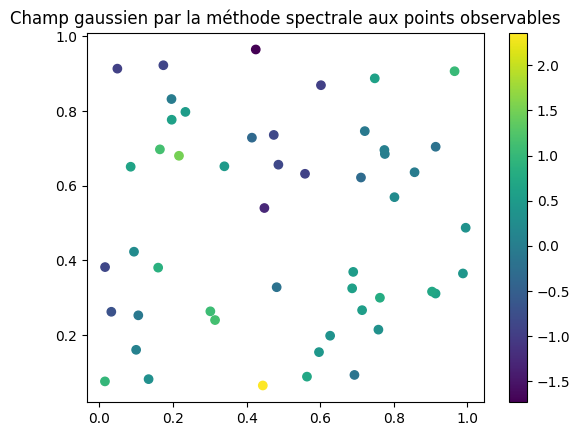

In [49]:
N=500
Gridtout=mspectrale(X,Y,a,N)

plt.scatter(X, Y, c=Gridtout, cmap='viridis')
plt.colorbar()
plt.title('Champ gaussien par la méthode spectrale aux points de la grille')

#Pour les points observables on ne peut pas avoir des tableaux 2D comme avec meshgrid
def mspectrale_points(x, y, a, N):
    points = np.stack((x, y), axis=-1)  
    phi = np.random.uniform(0, 2*np.pi, size=N)
    W = np.sqrt(2/a) * np.random.randn(N, 2)
    Yvals = np.sqrt(2/N) * np.sum(np.cos(points @ W.T + phi), axis=1)
    return Yvals 

Gridobs=mspectrale_points(obs_pts[:,0], obs_pts[:,1], a, N)
plt.figure()
plt.scatter(obs_pts[:,0], obs_pts[:,1], c=Gridobs, cmap='viridis')
plt.colorbar()
plt.title('Champ gaussien par la méthode spectrale aux points observables')
plt.show()

5. Générer 500 simulations conditionnelles et comparer la moyenne empirique de ces simulations avec l'espérance conditionnelle calculée précédemment. Que constate-t-on ? Expliquer pourquoi.

# Simulation non-stationnaire

On souhaite désormais simuler un champ aléatoire Gaussien non-stationnaire, c'est-à-dire dont la fonction de covariance dépend de la position dans le domaine. Ces modèles plus complexes offrent une plus grande flexibilité pour modéliser des phénomènes naturels. En particulier, on va chercher à faire varier la valeur du paramètre d'échelle $a$ en fonction de la position. On considère une fonction de covariance de la forme :
$$C(x, y) = 2\frac{\sqrt{a(x) a(y)}}{a(x)+a(y)} \exp\left(-\frac{2\|x - y\|^2}{a(x)+a(y)}\right),$$
où $a : [0,1]^2 \to \mathbb{R}_+^*$ est une fonction définissant le paramètre d'échelle en chaque point du domaine.

Pour générer des réalisations de ce champ aléatoire non-stationnaire, on peut adapter la méthode spectrale en utilisant une approche locale. Précisément, on va considérer la modification suivante de la méthode spectrale :

$$Z(x) = \sqrt{\frac{2f_x(W)}{g(W)}}\cos(\langle W, x \rangle + \Phi)$$

où $W$ et $\Phi$ sont deux variables aléatoires indépendantes, de lois respectives $\mathcal{N}(0, \frac{2}{a} I_2)$ et $\mathcal{U}[0, 2\pi[$, et où $f_x$ est la densité de la loi $\mathcal{N}(0, \frac{2}{a(x)} I_2)$ et $g$ est la densité de la loi $\mathcal{N}(0, \frac{2}{a} I_2)$ pour $a = \inf_{x \in [0,1]^2} a(x)>0$, avec $a>0$.

1. Justifier que cette modification permet de simuler un champ aléatoire Gaussien non-stationnaire avec la fonction de covariance donnée précédemment. Quelle technique de simulation vue en cours est-elle utilisée ici ?

2. Implémenter cette méthode pour simuler un champ aléatoire Gaussien non-stationnaire sur une grille régulière de points dans le domaine  $[0, 1] \times [0, 1]$. On choisira, par exemple, une fonction $a(x)$ variant linéairement selon l'axe des ordonnées entre deux valeurs $a_{min}=0.01$ et $a_{max}=0.1$ sur le domaine. Commenter les résultats obtenus.